# 1. SVM을 이용한 얼굴 인식 모델

## 1) SVM
- 선형 분류기(linear classifier)
- 일반화 성능을 최대화하는 장점이 있음

## 2) C 파라미터의 기능
- 실제 데이터는 노이즈가 존재함
- margin 내의 violation을 얼마나 허용할 것인가?  
  - C가 클수록, violation을 허용하지 않으므로 margin의 크기가 작아짐
  - C가 0에 가까울수록, violation을 허용하면서 margin의 크기가 커지도록 함  
  
<img src='rc/parameter_c.PNG' alt='c' width="800" heigh="600">  
<br>

## 3) 커널(kernel) 트릭
- 비선형 데이터도 분류 가능함
<img src='rc/svm_parameters.PNG' alt='parameters' width="800" heigh="600">  
<br>

- gamma 파라미터의 기능 예시
<img src='rc/parameter_gamma.PNG' alt='gamma' width="800" heigh="600">  
<br>

#### [reference] 
- [예제 코드] https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html 
- [SVM 파라미터 C 설명] https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-3%EC%84%9C%ED%8F%AC%ED%8A%B8-%EB%B2%A1%ED%84%B0-%EB%A8%B8%EC%8B%A0-SVM-%EC%8B%A4%EC%8A%B5
- [SVM 파라미터 gamma 설명] https://datascienceschool.net/view-notebook/69278a5de79449019ad1f51a614ef87c/

In [1]:
from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


"""
데이터셋 준비하기
"""

# 얼굴 데이터셋 다운로드
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# 데이터셋 shape 확인
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print(">> Total dataset size:")
print("(width, height): (%d, %d)" % (w,h))
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

>> Total dataset size:
(width, height): (37, 50)
n_samples: 1288
n_features: 1850
n_classes: 7


In [2]:
print(lfw_people.images.shape)
print(lfw_people.data.shape)
print(target_names)
print()

print(X[:10].shape)
print(y[:10].shape)
print(y[:10])

(1288, 50, 37)
(1288, 1850)
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']

(10, 1850)
(10,)
[5 6 3 1 0 1 3 4 3 0]


In [3]:
# 분류기 학습을 위해 임의로 훈련 집합(training set)과 테스트 집합(testing set)으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
"""
PCA를 사용하여 얼굴 이미지 데이터의 차원 축소
"""
n_components = 150

# PCA를 통한 상위 k개의 고유 벡터(eigenvector) 계산
print(">> Extracting the top %d eigenfaces from %d faces.." % (n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("done")
print()

# optional) eigenface 별도 저장 (1차원 벡터 -> 2차원 이미지 형태)
eigenfaces = pca.components_.reshape((n_components, h, w))

# 훈련 집합(training set)과 테스트 집합(testing set) 데이터 차원 축소 (계산된 상위 k개의 고유 벡터(eigenvector)로 데이터 투영)
print(">> Projecting the input data on the eigenfaces orthonormal basis..")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done")

>> Extracting the top 150 eigenfaces from 966 faces..
done

>> Projecting the input data on the eigenfaces orthonormal basis..
done


In [5]:
"""
SVM(support vector machine) 분류 모델 학습
"""

# 학습 시 grid search 방식으로 최적의 파라미터를 찾음
print(">> Fitting the classifier to the training set..")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5, iid=False)

# 모델 학습하기
t0 = time()
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print(">> Best estimator found by grid search:")
print(clf.best_estimator_)

>> Fitting the classifier to the training set..
done in 39.297s

>> Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [6]:
"""
학습에 사용되지 않은 테스트 집합(testing set)을 사용하여 분류기의 '일반화 성능' 평가
"""

print(">> Predicting people's names on the test set..")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))
print()

print(">> classification report")
print(classification_report(y_test, y_pred, target_names=target_names))
print()

print(">> confusion matrix")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))   # true label:rows, predicted label: cols

>> Predicting people's names on the test set..
done in 0.073s

>> classification report
                   precision    recall  f1-score   support

     Ariel Sharon       0.70      0.54      0.61        13
     Colin Powell       0.81      0.87      0.84        60
  Donald Rumsfeld       0.85      0.63      0.72        27
    George W Bush       0.85      0.98      0.91       146
Gerhard Schroeder       0.91      0.80      0.85        25
      Hugo Chavez       1.00      0.53      0.70        15
       Tony Blair       0.97      0.78      0.86        36

         accuracy                           0.85       322
        macro avg       0.87      0.73      0.78       322
     weighted avg       0.86      0.85      0.85       322


>> confusion matrix
[[  7   1   0   5   0   0   0]
 [  1  52   1   6   0   0   0]
 [  1   2  17   7   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   3  20   0   1]
 [  0   4   0   2   1   8   0]
 [  1   1   2   3   1   0  28]]


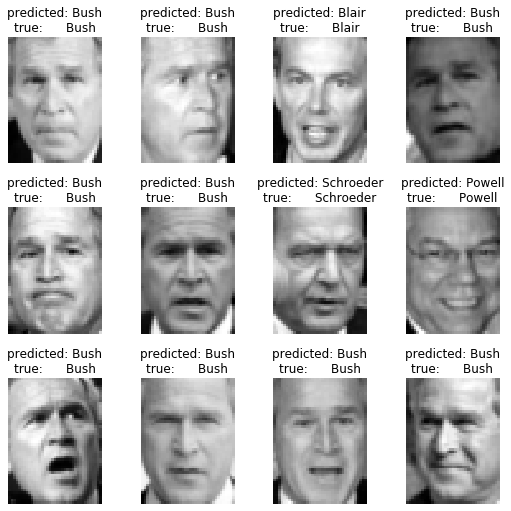

In [7]:
"""
예측 결과 시각화
"""
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.axis('off')


def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


# 예측 결과 시각화
prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)

plt.show()